# Convert exiting files to xmgrace

In [ ]:
import numpy as np
import os

number_of_voxels = 170 * 170
output_path = '/Users/arghavan/lab/hp-results/gZ/raw_data/'
os.makedirs(output_path, exist_ok=True)

for d in range(24, 151, 2):
    # d = 82
    d_in_angstrom = d / 10 
    input_file = f'/Users/arghavan/Graduate Center Dropbox/Arghavan Vedadi Gargari/MyFiles/gZ_data/{d}.out'

    data = np.loadtxt(input_file)
    
    x = data[:, 0]
    number_density = data[:, 1]/number_of_voxels

    dat_file = f"{output_path}{d_in_angstrom}A.dat"
    np.savetxt(dat_file, 
            np.column_stack((x, number_density)), 
            header='x (Angstrom)    g_z(O)', 
            comments='')

# Plot from XmGrace files

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# d = 58 #102
input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'
output_path = '/Users/arghavan/lab/hp-results/gZ/fixed_axis_plots/'
os.makedirs(output_path, exist_ok=True)

for d in range(58, 151, 2):
    d_in_angstrom = d / 10
    data_file = f'{input_path}{d_in_angstrom}A.dat'
    data = np.loadtxt(data_file, skiprows=1)

    x = data[:, 0]
    number_density = data[:, 1]

    plt.figure(figsize=(10, 6))
    plt.plot(x, number_density, 'bo-', markersize=3, label='Two Plate Interference')
    plt.hlines(y=1.00, xmin=18, xmax=32, color='black', linestyle='--', linewidth=1, label='Bulk Water')

    plt.text(20, 6, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
                bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
    plt.title(f'\nAverage Number Density')

    plt.xlabel('z (Å)')
    plt.ylabel(r'$g_z(O)$')

    plt.ylim(-0.2, 6.5)
    plt.xlim(17.5,32.5)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    plt.legend()

    plt.savefig(f"{output_path}/fixed_scale_gZ_{d_in_angstrom}.png", dpi=300)


# Fit a curve

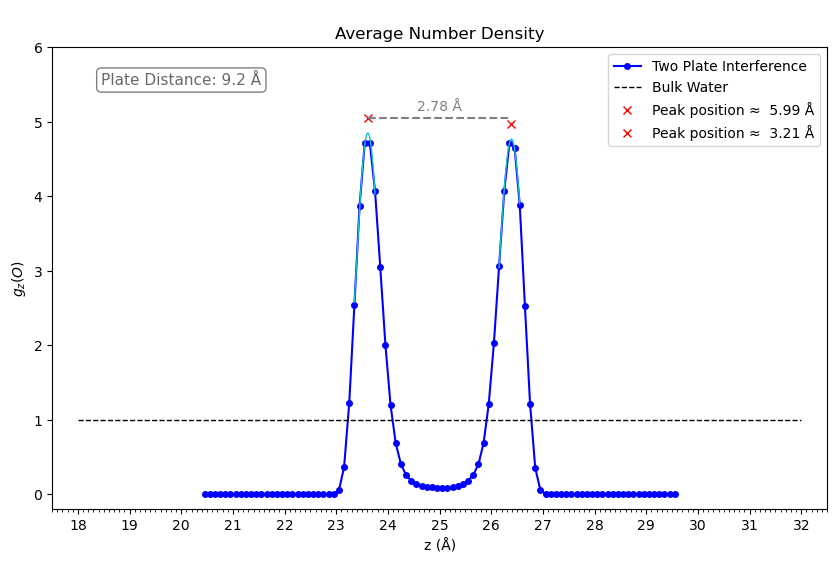

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker 

# d = 76 #102

for d in range(92, 93, 2):
    d_in_angstrom = d / 10
    input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'
    data_file = f'{input_path}{d_in_angstrom}A.dat'

    data = np.loadtxt(data_file, skiprows=1)

    x = data[:, 0]
    number_density = data[:, 1]

    def gaussian(x, a, x0, sigma):
        return a * np.exp(-((x - x0)**2) / (2 * sigma**2))
    ##----

    # find raw peaks
    peak_indices, _ = find_peaks(number_density, height=1.2) 
    x_peaks_init = x[peak_indices]

    fitted_peaks = []


    # data plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, number_density, 'bo-', markersize=4, label='Two Plate Interference')
    # plt.hlines(y=1.00, xmin=min(x), xmax=max(x), color='black', linestyle='--', linewidth=1, label='Bulk Water')
    plt.hlines(y=1.00, xmin=18, xmax=32, color='black', linestyle='--', linewidth=1, label='Bulk Water')
    
    # gaussian fit
    for x0_guess in x_peaks_init:
        
        # mask ±0.3 around initial peak guess
        mask = (x > x0_guess - 0.25) & (x < x0_guess + 0.25)
        x_fit = x[mask]
        y_fit = number_density[mask]
        
        if len(x_fit) < 5:
            continue

        # initial guess [a, x0, sigma]
        p0 = [np.max(y_fit), x0_guess, 0.2]

        try:
            popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            a_fit, x_peak, sigma_fit = popt
            y_peak = gaussian(x_peak, *popt)

            # saving peak info
            fitted_peaks.append((x_peak, y_peak))
            # fitting
            x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)
            peak_position = 25 + (d_in_angstrom/2) - x_peak
            plt.plot(x_dense, gaussian(x_dense, *popt), 'tab:cyan', linewidth = 1)
            plt.plot(x_peak, y_peak+0.2, 'rx', label=f'Peak position ≈  {peak_position:.2f} Å')

        except RuntimeError:
            print(f"Fit failed for peak near x = {x0_guess:.2f}")

    # show the distance 
    if len(fitted_peaks) >= 2:
        fitted_peaks.sort()  # sort by x
        x1, y1 = fitted_peaks[0]
        x2, y2 = fitted_peaks[1]
        y_line = max(y1, y2)
        plt.hlines(y=y_line+0.2, xmin=x1, xmax=x2, color='gray', linestyle='--')
        plt.text((x1 + x2) / 2, y_line + 0.3, f"{x2 - x1:.2f} Å", ha='center', fontsize=10, color='gray')
        # plt.text(x1, y_line + 0.1, f"{y1:.2f}", ha='center', fontsize=10, color='gray')
        # plt.text(x2, y_line + 0.1, f"{y2:.2f}", ha='center', fontsize=10, color='gray')

    plt.text(20, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
             bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
    # plt.text(25, 5.63, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='black',
    #          bbox=dict(facecolor='white', edgecolor='k', boxstyle='round,pad=0.3'))
    plt.title(f'\nAverage Number Density')
    plt.xlabel('z (Å)')
    plt.ylabel(r'$g_z(O)$')
    plt.legend()
    plt.ylim(-0.2, 6)
    plt.xlim(17.5,32.5)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    plt.savefig(f"{input_path}/data_peak_gZ_{d_in_angstrom}.png", dpi=300)

# WORKING ON THIS CELL NOW

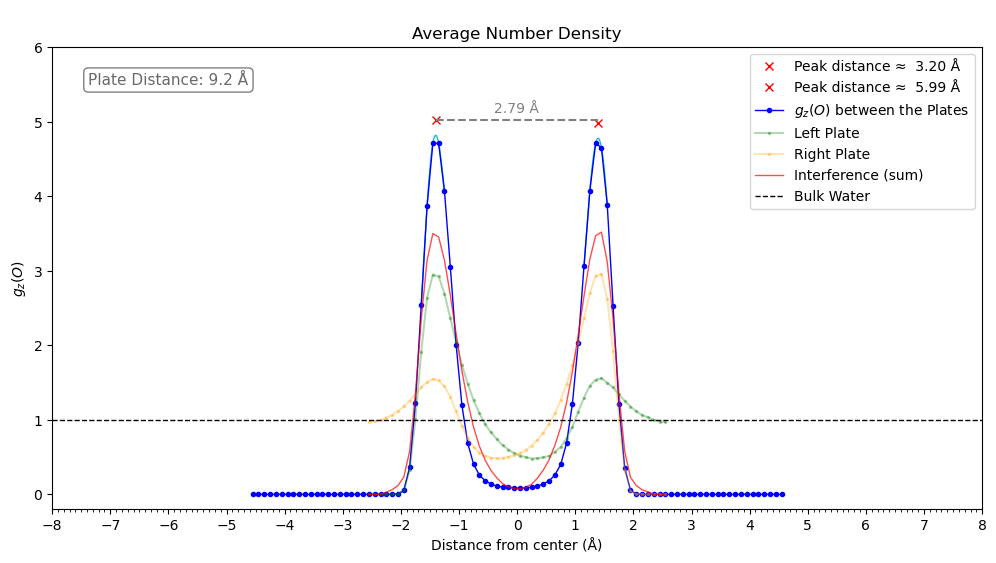

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker 
import pandas as pd

d  = 92
d_in_angstrom = d / 10
plt.figure(figsize=(12, 6))

# ===========================================================================================================================
#                                                       Loading Data
# ===========================================================================================================================

twoPlate_input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'
twoplate_file = f'{twoPlate_input_path}{d_in_angstrom}A.dat'

twoplate_df = pd.read_csv(twoplate_file, header=0, sep='\s+')

twoplate_x = twoplate_df['x(Angstrom)']
twoplate_numDens = twoplate_df['g_z(O)']


leftside_density_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
rightside_density_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-rightSide.dat'

leftside_df = pd.read_csv(leftside_density_file, header=0, sep='\s+')
rightside_df = pd.read_csv(rightside_density_file, header=0, sep='\s+')

x_left = leftside_df['x(Angstrom)']
numDens_left = leftside_df['g_z(O)']

x_right = rightside_df['x(Angstrom)']
numDens_right = rightside_df['g_z(O)']



twoplate_x_centered = (twoplate_x - 25).round(2)

# ===========================================================================================================================
#                       shift the one-plate graphs to align with the start and end point of two-plate graph
# ===========================================================================================================================

x_left_shifted = (twoplate_x_centered.iloc[0] + (x_left - x_left.iloc[0])).round(2)
x_right_shifted = (twoplate_x_centered.iloc[-1] - (x_right.iloc[-1] - x_right)).round(2)

# ===========================================================================================================================
#          truncate the one-plate datasets to only include the region where they overlap with the two-plate dataset
# ===========================================================================================================================

x_min = np.min(twoplate_x_centered)
x_max = np.max(twoplate_x_centered)


# Truncate left dataset
mask_left = (x_left_shifted >= x_min) & (x_left_shifted <= x_max)
x_left_trimmed = x_left_shifted[mask_left]
numDens_left_trim = numDens_left[mask_left]

# Truncate right dataset
mask2 = (x_right_shifted >= x_min) & (x_right_shifted <= x_max)
x_right_trimmed = x_right_shifted[mask2]
numDens_right_trim = numDens_right[mask2]
# ===========================================================================================================================
#                                         Interference of the two one-plate graphs
# ===========================================================================================================================

interference = numDens_left_trim.values + numDens_right_trim.values - 1
interference = np.clip(interference, a_min=0, a_max=None)

twoplate_numDens_vals = twoplate_numDens.values

# ===========================================================================================================================
#                 Truncatung data to only include the region where densities between the plates is non-zero
# ===========================================================================================================================


first_nonzero = np.argmax(twoplate_numDens_vals != 0)  # first index where twoplate_numDens != 0
last_nonzero = len(twoplate_numDens_vals) - np.argmax(twoplate_numDens_vals[::-1] != 0) - 1  # last index where twoplate_numDens != 0

n_keep_zeros = 4 # number of zeros to keep before the first non-zero

# compute starting index safely
start_idx = max(0, first_nonzero - n_keep_zeros)
end_idx = min(len(twoplate_numDens_vals), last_nonzero + n_keep_zeros + 1) 


mask = np.zeros_like(twoplate_numDens_vals, dtype=bool)
mask[start_idx:end_idx] = True  # only keep this region

x_left_trimmed_masked = x_left_trimmed[mask]
numDens_left_trim_masked = numDens_left_trim[mask]

x_right_trimmed_masked = x_right_trimmed[mask]
numDens_right_trim_masked = numDens_right_trim[mask]

interference_masked = interference[mask]
# ===========================================================================================================================
#                                                   fitting peaks
# ===========================================================================================================================


peak_indices, _ = find_peaks(twoplate_numDens, height=1.2)                    # any maximum lower than 1.2 is not considered a peak (to avoid minimums and only look for peaks above bulk water level)
x_peaks_init = twoplate_x_centered[peak_indices]   


fitted_peaks = []


degree = 4

for x0_guess in x_peaks_init:
    
    # mask ±0.25 around initial peak guess
    mask = (twoplate_x_centered > x0_guess - 0.25) & (twoplate_x_centered < x0_guess + 0.25)
    x_fit = twoplate_x_centered[mask]
    y_fit = twoplate_numDens[mask]
    
    if len(x_fit) < degree + 1:
        continue
    coeffs = np.polyfit(x_fit, y_fit, deg=degree)
    poly = np.poly1d(coeffs)

    x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)
    y_dense = poly(x_dense)
    max_idx = np.argmax(y_dense)
    x_peak = x_dense[max_idx]
    y_peak = y_dense[max_idx] 

    # saving peak info
    fitted_peaks.append((x_peak, y_peak))
    peak_position = (d_in_angstrom/2) + x_peak
    # peak_position = twoplate_x_centered.iloc[0] + (d_in_angstrom/2) - x_peak
    plt.plot(x_dense, y_dense, 'tab:cyan', linewidth = 1)
    # plt.plot(x_peak, y_peak+0.2, 'rx', label=f'Peak ≈  {x_peak:.2f} Å')
    plt.plot(x_peak, y_peak+0.2, 'rx', label=f'Peak distance ≈  {peak_position:.2f} Å')

# show the distance 
if len(fitted_peaks) >= 2:
    fitted_peaks.sort()  # sort by x
    x1, y1 = fitted_peaks[0]
    x2, y2 = fitted_peaks[1]
    y_line = max(y1, y2)
    plt.hlines(y=y_line+0.2, xmin=x1, xmax=x2, color='gray', linestyle='--')
    plt.text((x1 + x2) / 2, y_line + 0.3, f"{x2 - x1:.2f} Å", ha='center', fontsize=10, color='gray')


# ===========================================================================================================================
#                                                   Plotting
# ===========================================================================================================================


plt.plot(twoplate_x_centered, twoplate_numDens, 'bo-', markersize=3, linewidth=1, label=r'$g_z(O)$ between the Plates')
plt.plot(x_left_trimmed_masked, numDens_left_trim_masked, label='Left Plate', marker='o', color='green',markersize='1.5', alpha=0.3)
plt.plot(x_right_trimmed_masked, numDens_right_trim_masked, label='Right Plate', marker='o', color='orange',markersize='1.5', alpha=0.3)
plt.plot(x_left_trimmed_masked, interference_masked, label='Interference (sum)', linestyle='-', linewidth=1, color='red', alpha=0.7)


plt.hlines(y=1.00, xmin=-8, xmax=8, color='black', linestyle='--', linewidth=1, label='Bulk Water')

plt.text(-6, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.title(f'\nAverage Number Density')
plt.xlabel('Distance from center (Å)')
plt.ylabel(r'$g_z(O)$')
plt.legend()
plt.ylim(-0.2, 6)
plt.xlim(-8,8)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


# plt.savefig(f'/Users/arghavan/lab/hp-results/gZ/paper_figures/{d_in_angstrom}_peak_distance.png', dpi=600)

# THE REST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker 
import pandas as peak_indices


# ===========================================================================================================================
#                                                       Loading Data
# ===========================================================================================================================

leftside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
rightside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-rightSide.dat'


leftside_data = np.loadtxt(leftside_file, skiprows=1)
rightside_data = np.loadtxt(rightside_file, skiprows=1)


x_left = leftside_data[:, 0]
number_density_left = leftside_data[:, 1]

x_right = rightside_data[:, 0]
number_density_right = rightside_data[:, 1]



input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'


d  = 92           # change this to input to automate
d_in_angstrom = d / 10

data_file = f'{input_path}{d_in_angstrom}A.dat'

gZ = np.loadtxt(data_file, skiprows=1)

x = gZ[:, 0]
number_density = gZ[:, 1]





# ===========================================================================================================================
#                                                 finding peaks and fitting
# ===========================================================================================================================



def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))


# find raw peaks
peak_indices, _ = find_peaks(number_density, height=1.2)                    # any maximum lower than 1.2 is not considered a peak (to avoid minimums and only look for peaks above bulk water level)
x_peaks_init = x[peak_indices]                                              # the x value of the peaks, to be used as initial guess for fitting

fitted_peaks = []


# ===========================================================================================================================
#                       shift the one-plate graphs to align with the start and end point of two-plate graph
# ===========================================================================================================================


# x_left_shifted = x[0] + (x_left - x_left[0])
# x_right_shifted = x[-1] - (x_right[-1] - x_right)



# ===========================================================================================================================
#          truncate the one-plate datasets to only include the region where they overlap with the two-plate dataset
# ===========================================================================================================================

# x_min = np.min(x)
# x_max = np.max(x)



# # Truncate left dataset
# mask1 = (x_left_shifted >= x_min) & (x_left_shifted <= x_max)
# x_left_trimmed = x_left_shifted[mask1]
# numdens_left_trim = number_density_left[mask1]

# # Truncate right dataset
# mask2 = (x_right_shifted >= x_min) & (x_right_shifted <= x_max)
# x_right_trimmed = x_right_shifted[mask2]
# numdens_right_trim = number_density_right[mask2]

# interference = number_density_left + number_density_right

# ===========================================================================================================================
#                       interpolate them to the same x values as the two-plate dataset
# # ===========================================================================================================================

# x_common = np.linspace(
#     max(x_left_shifted.min(), x_right_shifted.min()),
#     min(x_left_shifted.max(), x_right_shifted.max()),
#     d
# )

# y1_interp = np.interp(x_common, x_left_trimmed, numdens_left_trim)
# y2_interp = np.interp(x_common, x_right_trimmed, numdens_right_trim)

# # --- Sum them ---
# interference = y1_interp + y2_interp

# mask = interference < 1
# x_mid = 0.5 * (x_left_trimmed.min() + x_left_trimmed.max())
# # mask_1 = mask & (x_left_trimmed >= x_mid)
# # mask_2  = mask & (x_right_trimmed <  x_mid) 

# interference_fixed = interference.copy()
# numdens_left_fixed = numdens_left_trim.copy()
# numdens_right_fixed = numdens_right_trim.copy()
# interference_fixed[mask] = 1
# numdens_left_fixed[mask_1] = 1
# numdens_right_fixed[mask_2] = 1


# data plotting
plt.figure(figsize=(12, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label=r'$g_z(O)$ between the Two Plates')

# plt.plot(x_left_trimmed, numdens_left_fixed, label='Left Plate', marker='o',markersize='2', color='orange', alpha=0.5)
# plt.plot(x_right_trimmed, numdens_right_fixed, label='Right Plate', marker='o', color='green',markersize='3', alpha=0.5)
# plt.plot(x, interference_fixed, label='Interference', color = 'red', alpha=0.5)

plt.hlines(y=1.00, xmin=18, xmax=32, color='black', linestyle='--', linewidth=1, label='Bulk Water')

# gaussian fit
for x0_guess in x_peaks_init:
    
    # mask ±0.3 around initial peak guess
    mask = (x > x0_guess - 0.25) & (x < x0_guess + 0.25)
    x_fit = x[mask]
    y_fit = number_density[mask]
    
    if len(x_fit) < 5:
        continue

    # initial guess [a, x0, sigma]
    p0 = [np.max(y_fit), x0_guess, 0.2]

    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        a_fit, x_peak, sigma_fit = popt
        y_peak = gaussian(x_peak, *popt)

        # saving peak info
        fitted_peaks.append((x_peak, y_peak))
        # fitting
        x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)
        # plt.plot(x_dense, gaussian(x_dense, *popt), 'tab:cyan', linewidth = 1, label='Gaussian Fit' if 'Gaussian Fit' not in plt.gca().get_legend_handles_labels()[1] else "")
        # plt.plot(x_peak, y_peak+0.2, 'rx', label=f'Peak ≈  {x_peak:.2f} Å')

    except RuntimeError:
        print(f"Fit failed for peak near x = {x0_guess:.2f}")

# show the distance 
if len(fitted_peaks) >= 2:
    fitted_peaks.sort()  # sort by x
    x1, y1 = fitted_peaks[0]
    x2, y2 = fitted_peaks[1]
    y_line = max(y1, y2)
    # plt.hlines(y=y_line+0.2, xmin=x1, xmax=x2, color='gray', linestyle='--')
    # plt.text((x1 + x2) / 2, y_line + 0.3, f"{x2 - x1:.2f} Å", ha='center', fontsize=10, color='gray')


plt.text(20, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.title(f'\nAverage Number Density')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.legend()
plt.ylim(-0.2, 6)
plt.xlim(-0.6, 15.6)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# plt.savefig(f'/Users/arghavan/lab/hp-results/all_5_gZ_{d_in_angstrom}.png', dpi=600)

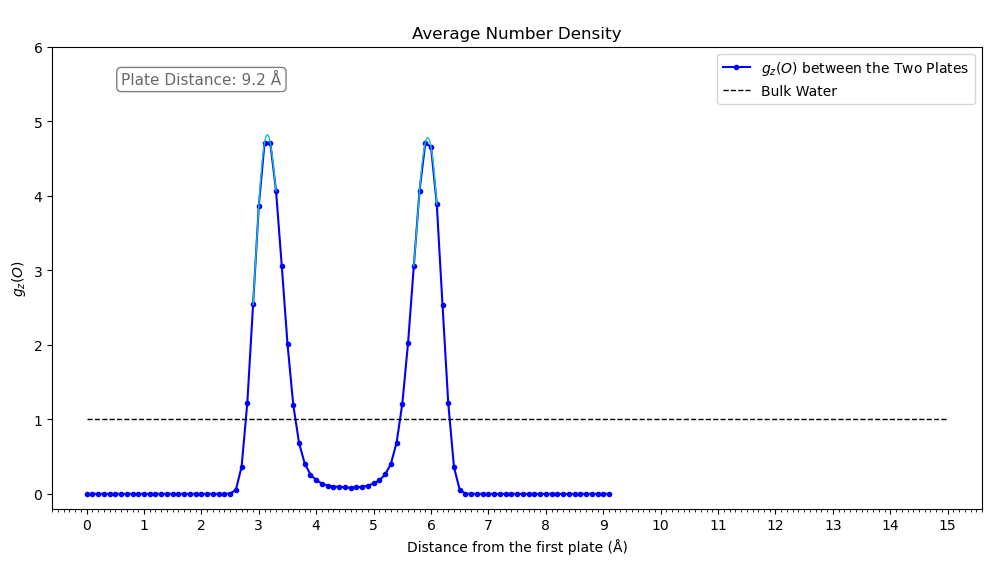

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker 
import pandas as peak_indices


# ===========================================================================================================================
#                                                       Loading Data
# ===========================================================================================================================

leftside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
rightside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-rightSide.dat'


leftside_data = np.loadtxt(leftside_file, skiprows=1)
rightside_data = np.loadtxt(rightside_file, skiprows=1)


x_left = leftside_data[:, 0]
number_density_left = leftside_data[:, 1]

x_right = rightside_data[:, 0]
number_density_right = rightside_data[:, 1]



input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'


d  = 92           # change this to input to automate
d_in_angstrom = d / 10

data_file = f'{input_path}{d_in_angstrom}A.dat'

gZ = np.loadtxt(data_file, skiprows=1)

x = gZ[:, 0]
x = x - x[0]
number_density = gZ[:, 1]





# ===========================================================================================================================
#                                                 finding peaks and fitting
# ===========================================================================================================================


# find raw peaks
peak_indices, _ = find_peaks(number_density, height=1.2)                    # any maximum lower than 1.2 is not considered a peak (to avoid minimums and only look for peaks above bulk water level)
x_peaks_init = x[peak_indices]                                              # the x value of the peaks, to be used as initial guess for fitting

fitted_peaks = []

# data plotting
plt.figure(figsize=(12, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label=r'$g_z(O)$ between the Two Plates')

plt.hlines(y=1.00, xmin=0, xmax=15, color='black', linestyle='--', linewidth=1, label='Bulk Water')

degree = 4

for x0_guess in x_peaks_init:
    
    # mask ±0.3 around initial peak guess
    mask = (x > x0_guess - 0.25) & (x < x0_guess + 0.25)
    x_fit = x[mask]
    y_fit = number_density[mask]
    
    if len(x_fit) < degree + 1:
        continue
    coeffs = np.polyfit(x_fit, y_fit, deg=degree)
    poly = np.poly1d(coeffs)

    x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)
    y_dense = poly(x_dense)
    max_idx = np.argmax(y_dense)
    x_peak = x_dense[max_idx]
    y_peak = y_dense[max_idx] 

    # saving peak info
    fitted_peaks.append((x_peak, y_peak))

    plt.plot(x_dense, y_dense, 'tab:cyan', linewidth = 1)
    # plt.plot(x_peak, y_peak+0.2, 'rx', label=f'Peak ≈  {x_peak:.2f} Å')


# show the distance 
if len(fitted_peaks) >= 2:
    fitted_peaks.sort()  # sort by x
    x1, y1 = fitted_peaks[0]
    x2, y2 = fitted_peaks[1]
    y_line = max(y1, y2)
    # plt.hlines(y=y_line+0.2, xmin=x1, xmax=x2, color='gray', linestyle='--')
    # plt.text((x1 + x2) / 2, y_line + 0.3, f"{x2 - x1:.2f} Å", ha='center', fontsize=10, color='gray')


plt.text(2, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.title(f'\nAverage Number Density')
plt.xlabel('Distance from the first plate (Å)')
plt.ylabel(r'$g_z(O)$')
plt.legend()
plt.ylim(-0.2, 6)
plt.xlim(-0.6, 15.6)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# plt.savefig(f'/Users/arghavan/lab/hp-results/all_5_gZ_{d_in_angstrom}.png', dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker 
import pandas as peak_indices


# ===========================================================================================================================
#                                                       Loading Data
# ===========================================================================================================================

leftside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
rightside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-rightSide.dat'


leftside_data = np.loadtxt(leftside_file, skiprows=1)
rightside_data = np.loadtxt(rightside_file, skiprows=1)


x_left = leftside_data[:, 0]
number_density_left = leftside_data[:, 1]

x_right = rightside_data[:, 0]
number_density_right = rightside_data[:, 1]



input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'


d  = 92           # change this to input to automate
d_in_angstrom = d / 10

data_file = f'{input_path}{d_in_angstrom}A.dat'

gZ = np.loadtxt(data_file, skiprows=1)

x = gZ[:, 0]
number_density = gZ[:, 1]


def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))


# find raw peaks
peak_indices, _ = find_peaks(number_density, height=1.2) 
x_peaks_init = x[peak_indices]
x_peaks_init



In [ ]:
x_common = np.linspace(
    max(x_left_shifted.min(), x_right_shifted.min()),
    min(x_left_shifted.max(), x_right_shifted.max()),
    92
)
x_common

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker 

# ===========================================================================================================================
#                                                       Loading Data
# ===========================================================================================================================

leftside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
rightside_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-rightSide.dat'


leftside_data = np.loadtxt(leftside_file, skiprows=1)
rightside_data = np.loadtxt(rightside_file, skiprows=1)


x_left = leftside_data[:, 0]
number_density_left = leftside_data[:, 1]

x_right = rightside_data[:, 0]
number_density_right = rightside_data[:, 1]


d_in_angstrom = 9.2

input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'
data_file = f'{input_path}{d_in_angstrom}A.dat'

data = np.loadtxt(data_file, skiprows=1)

x = data[:, 0]
number_density = data[:, 1]


# ------------------------------------- Gaussian Fitting -------------------------------------

def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

# find raw peaks
peak_indices, _ = find_peaks(number_density, height=1.2) 
x_peaks_init = x[peak_indices]

fitted_peaks = []




# ------------------------------- Shifting and Truncating left and right gZ --------------------------------
x_left_shifted = x[0] + (x_left - x_left[0])
x_right_shifted = x[-1] - (x_right[-1] - x_right)

x_min = np.min(x)
x_max = np.max(x)

# Truncate dataset 1
mask1 = (x_left_shifted >= x_min) & (x_left_shifted <= x_max)
x_left_trimmed = x_left_shifted[mask1]
numdens_left_trim = number_density_left[mask1]

# Truncate dataset 2
mask2 = (x_right_shifted >= x_min) & (x_right_shifted <= x_max)
x_right_trimmed = x_right_shifted[mask2]
numdens_right_trim = number_density_right[mask2]


# ------------------------------------- Interference  -------------------------------------
# interference = number_density_left + number_density_right

x_common = np.linspace(
    max(x_left_shifted.min(), x_right_shifted.min()),
    min(x_left_shifted.max(), x_right_shifted.max()),
    92
)

y1_interp = np.interp(x_common, x_left_trimmed, numdens_left_trim)
y2_interp = np.interp(x_common, x_right_trimmed, numdens_right_trim)

interference = y1_interp + y2_interp

mask = interference < 1
x_mid = 0.5 * (x_left_trimmed.min() + x_left_trimmed.max())
# mask_1 = mask & (x_left_trimmed >= x_mid)
# mask_2  = mask & (x_right_trimmed <  x_mid) 

interference_fixed = interference.copy()
numdens_left_fixed = numdens_left_trim.copy()
numdens_right_fixed = numdens_right_trim.copy()
interference_fixed[mask] = 1
# numdens_left_fixed[mask_1] = 1
# numdens_right_fixed[mask_2] = 1


# -------------------------------------  peak plotting -------------------------------------
plt.figure(figsize=(12, 6))

# gaussian fit
for x0_guess in x_peaks_init:
    
    # mask ±0.3 around initial peak guess
    mask = (x > x0_guess - 0.25) & (x < x0_guess + 0.25)
    x_fit = x[mask]
    y_fit = number_density[mask]
    
    if len(x_fit) < 5:
        continue

    # initial guess [a, x0, sigma]
    p0 = [np.max(y_fit), x0_guess, 0.2]

    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        a_fit, x_peak, sigma_fit = popt
        y_peak = gaussian(x_peak, *popt)

        # saving peak info
        fitted_peaks.append((x_peak, y_peak))
        # fitting
        x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)
        plt.plot(x_dense, gaussian(x_dense, *popt), 'tab:cyan', linewidth = 1, label='Fitted Peak' if 'Fitted Peak' not in plt.gca().get_legend_handles_labels()[1] else "")
        # plt.plot(x_peak, 4., 'rx')
        print(f"Fitted peak at x = {x_peak:.2f} Å with height = {y_peak:.2f}")

    except RuntimeError:
        print(f"Fit failed for peak near x = {x0_guess:.2f}")

# show the distance 
if len(fitted_peaks) >= 2:
    fitted_peaks.sort()  # sort by x
    x1, y1 = fitted_peaks[0]
    x2, y2 = fitted_peaks[1]
    y_line = max(y1, y2)
    plt.hlines(y=y_line+0.2, xmin=x1, xmax=x2, color='gray', linestyle='--')
    plt.text((x1 + x2) / 2, y_line + 0.3, f"{x2 - x1:.2f} Å", ha='center', fontsize=10, color='gray')

# ------------------------------------- Main Plotting -------------------------------------
plt.plot(x, number_density, 'bo-', markersize=4, label='Two Plate Interference')

plt.plot(x_left_trimmed, numdens_left_fixed, label='Left Plate', marker='o',markersize='2', color='orange', alpha=0.5)
plt.plot(x_right_trimmed, numdens_right_fixed, label='Right Plate', marker='o', color='green',markersize='3', alpha=0.5)
plt.plot(x, interference_fixed, label='Interference', color = 'red', alpha=0.5)

plt.hlines(y=1.00, xmin=18, xmax=32, color='black', linestyle='--', linewidth=1, label='Bulk Water')


plt.text(20, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.title(f'\nAverage Number Density')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.legend()
plt.ylim(-0.2, 6)
plt.xlim(17.5,32.5)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


In [ ]:
y_line

In [ ]:


x = data[:, 0]
number_density = data[:, 1]

def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

# first peak
mask1 = (x > 23.42) & (x < 23.8)
x1 = x[mask1]
y1 = number_density[mask1]
p0_1 = [np.max(y1), x1[np.argmax(y1)], 0.2]
popt1, _ = curve_fit(gaussian, x1, y1, p0=p0_1)
a1, x_peak1, sigma1 = popt1
y_peak1 = gaussian(x_peak1, *popt1)

# second peak
mask2 = (x > 26.2) & (x < 26.58)
x2 = x[mask2]
y2 = number_density[mask2]
p0_2 = [np.max(y2), x2[np.argmax(y2)], 0.2]
popt2, _ = curve_fit(gaussian, x2, y2, p0=p0_2)
a2, x_peak2, sigma2 = popt2
y_peak2 = gaussian(x_peak2, *popt2)

# plotting the data
plt.figure(figsize=(9, 6))
plt.title(f'\nAverage Number Density - {d_in_angstrom} Plate Distance\n')
plt.xlabel('x (Å)')
plt.ylabel(r'$g_z(O)$')
plt.plot(x, number_density, color='blue', linewidth=1, marker='o', markersize=4, label='Two Plate Interference')

# plotting gaussian fits
x_dense1 = np.linspace(x1.min(), x1.max(), 500)
x_dense2 = np.linspace(x2.min(), x2.max(), 500)
# plt.plot(x_dense1, gaussian(x_dense1, *popt1), 'g', label='Gaussian Fit 1')
plt.plot(x_dense1, gaussian(x_dense1, *popt1), 'tab:cyan')
plt.plot(x_dense2, gaussian(x_dense2, *popt2), 'tab:cyan')

# marking the peaks
plt.plot(x_peak1, y_peak1, color='tab:red', markersize=7, marker='x', label=f'Peak 1 ≈ {x_peak1:.2f} Å')
plt.plot(x_peak2, y_peak2, color='tab:red', markersize=7, marker='x', label=f'Peak 2 ≈ {x_peak2:.2f} Å')

# draw a line between the peaks
y_line = max(y_peak1, y_peak2)
plt.hlines(y=y_line, xmin=x_peak1, xmax=x_peak2, color='gray', linestyle='--', linewidth=1)

# peak difference
x_center = (x_peak1 + x_peak2) / 2
peak_x_diff = abs(x_peak2 - x_peak1)
plt.text(x_center, y_line + 0.1, f"{peak_x_diff:.2f} Å", ha='center', va='bottom', fontsize=10, color='gray')

# formatting
plt.axhline(y=1.00, color='black', linewidth=1, linestyle='-', label='Bulk Water')
plt.legend()
plt.ylim(-0.2, 6)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.savefig(f"{input_path}/fit_gZ_{d_in_angstrom}.png", dpi=300)
# plt.tight_layout()
# plt.show()


# Rest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

d = 82
d_in_angstrom = d / 10 
input_file = f'/Users/arghavan/Graduate Center Dropbox/Arghavan Vedadi Gargari/MyFiles/gZ_data/{d}.out'
output_path = '/Users/arghavan/lab/hp-results/gz-data/'
data = np.loadtxt(input_file)

In [ ]:
number_of_voxels = 170 * 170
x = data[:, 0]
number_density = data[:, 1]/number_of_voxels

dat_file = f"{output_path}{d_in_angstrom}A.dat"
np.savetxt(dat_file, 
           np.column_stack((x, number_density)), 
           header='x (Angstrom)    g_z(O)', 
           comments='')


In [ ]:
peaks, _ = find_peaks(number_density)  # peaks is an array indicating where the peaks are (which indices in number_density or x are peaks)

x_peaks = x[peaks] # x values of the peaks
numDens_peaks = number_density[peaks] # gO values of the peaks


plt.figure(figsize=(9, 6))
plt.title(f'\nAverage Number Density - {d_in_angstrom} Plate Distance\n')
# plt.suptitle('8.2 Plate Distance')
plt.xlabel('x (Å)')
plt.ylabel(r'$g_z(O)$')
plt.plot(x, number_density, color='blue', linewidth=1, marker='o', markersize=4, label='Two Plate Interference')
plt.plot(x_peaks, numDens_peaks, "rx")  # red x at peaks
plt.axhline(y=1.00, color='black', linewidth=1, linestyle='-', label='Bulk Water')
plt.legend()
plt.ylim(-0.1, 3)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))    
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))   


if x_peaks[0] > x_peaks[1]:
    x_peaks[0], x_peaks[1] = x_peaks[1], x_peaks[0]
    numDens_peaks[0], numDens_peaks[1] = numDens_peaks[1], numDens_peaks[0]


y_line = max(numDens_peaks[0], numDens_peaks[1]) # a y-position for the line at the taller peak


plt.hlines(y=y_line, xmin=x_peaks[0], xmax=x_peaks[1], color='gray', linestyle='--', linewidth=1) # draw horizontal line between peaks

# Calculate the x-difference
peak_x_diff = x_peaks[1] - x_peaks[0]
x_center = (x_peaks[0] + x_peaks[1]) / 2
plt.text(x_center, y_line + 0.05, f"{peak_x_diff:.2f} Å", ha='center', va='bottom', fontsize=10, color='gray')

plt.savefig(f"{output_path}/gZ_{d_in_angstrom}.png", dpi=300)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

d = 82
d_in_angstrom = d / 10 
input_file = f'/Users/arghavan/Graduate Center Dropbox/Arghavan Vedadi Gargari/MyFiles/gZ_data/{d}.out'
output_path = '/Users/arghavan/lab/hp-results/gz-data/'
data = np.loadtxt(input_file)